# Sparks Foundation Internship Submission

## Stock Market Prediction using Numerical and Textual Analysis (2010-2020)

Datasets: https://bit.ly/36fFPI6 (TOI new headlines), SENSEX (S&P BSE SENSEX)

Name: Karumuri Naga Anjaneyulu

Internship Role: Data Science and Business Analytics

Task 1

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import pandas_datareader as pdr
from datetime import datetime
stock_price = pdr.get_data_yahoo('^BSESN', start = datetime(2010,1,1), end = datetime(2020, 12, 31))

In [4]:
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [5]:
len(stock_price), len(stock_headlines)

(2701, 3424067)

In [6]:
stock_price.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,17582.839844,17378.380859,17473.449219,17558.730469,28200.0,17558.730469
2010-01-05,17729.779297,17555.769531,17555.769531,17686.240234,27000.0,17686.240234
2010-01-06,17790.330078,17636.710938,17719.470703,17701.130859,21400.0,17701.130859
2010-01-07,17733.339844,17566.539062,17701.970703,17615.720703,18000.0,17615.720703
2010-01-08,17658.119141,17508.960938,17603.869141,17540.289062,17200.0,17540.289062


In [7]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [8]:
stock_price.isna().any(), stock_headlines.isna().any()

(High         False
 Low          False
 Open         False
 Close        False
 Volume       False
 Adj Close    False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

## Stock Prices

First lets clean the data.

We drop any null values and duplicate values

In [9]:
stock_price.dropna(inplace = True)
stock_price.drop_duplicates(inplace = True)

Plot the opening price

Text(0, 0.5, 'Open')

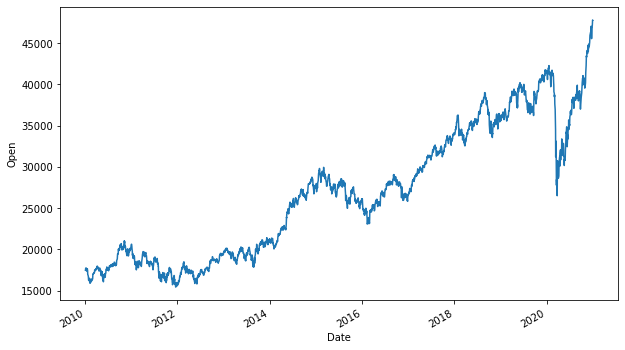

In [10]:
plt.figure(figsize=(10, 6))
stock_price['Open'].plot()
plt.ylabel('Open')

Plot the moving average for closing prices

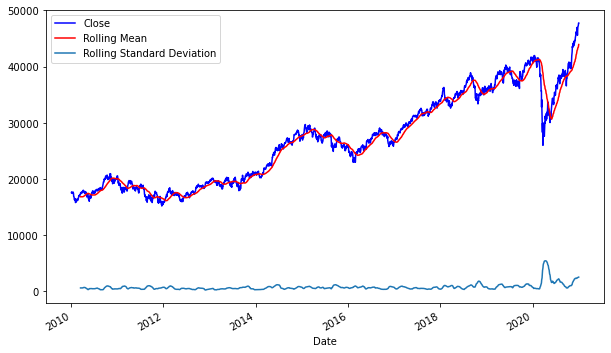

In [11]:
close = stock_price['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10,6))
stock_price['Close'].plot(color = 'b', label = 'Close')
ma.plot( color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Plot the returns 

Text(0.5, 1.0, 'Returns')

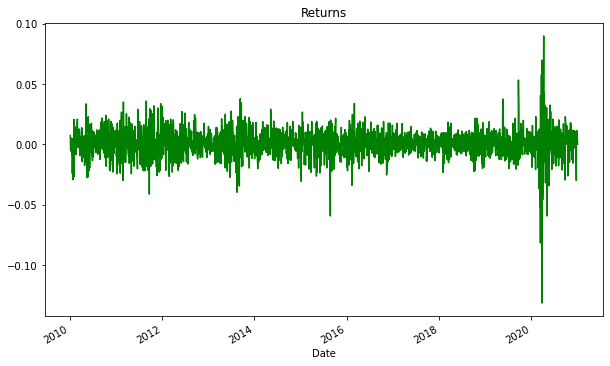

In [12]:
returns = close/close.shift(1) - 1

plt.figure(figsize = (10, 6))
returns.plot(label = 'Return', color = 'g')
plt.title("Returns")

To determine the stationarity of a timeseries, we can Dicky Fuller test and the code for that goes as follows

In [13]:
#Stationarity test
def test_stationarity(timeseries):
    
    #Determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    
    #plot the rolling statistics
    plt.figure(figsize = (10,10))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 20)
    plt.show(block = False)
    
    print('Results of Dickey Fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(HO), reject the null hypothesis. Data is stationary")
    else: print("Weak evidence against the null hypothesis, time series is non-stationary")

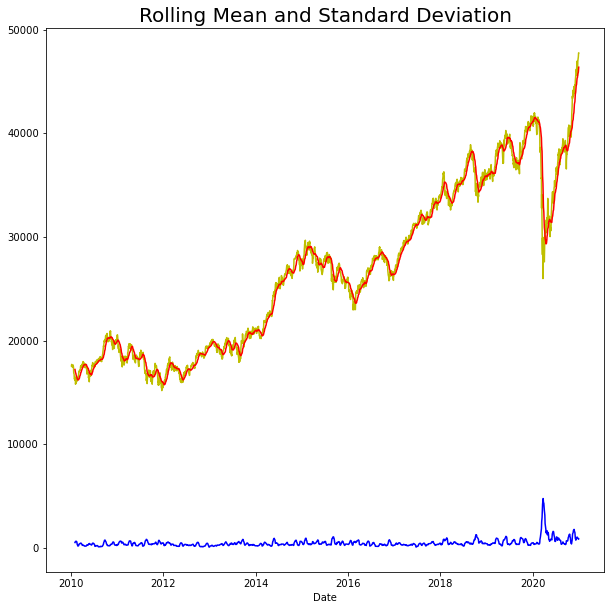

Results of Dickey Fuller test
ADF Test Statistic : 0.08573780569096898
P-Value : 0.9650737492176141
#Lags Used : 12
Number of Observations Used : 2688
Weak evidence against the null hypothesis, time series is non-stationary


In [14]:
test_stationarity(stock_price['Close'])

Lets split the data into train and test

In [15]:
train = stock_price[:2200]
test = stock_price[2200:]

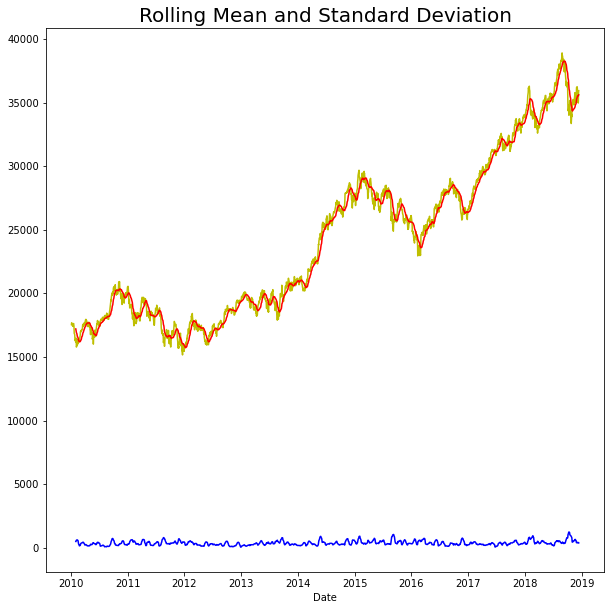

Results of Dickey Fuller test
ADF Test Statistic : -0.19546670702820454
P-Value : 0.9390598210385205
#Lags Used : 1
Number of Observations Used : 2198
Weak evidence against the null hypothesis, time series is non-stationary


In [16]:
test_stationarity(train['Close'])

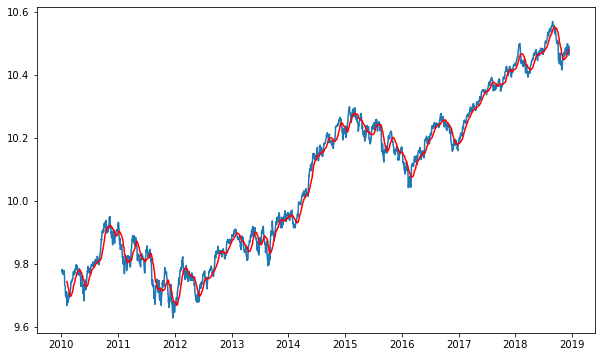

In [17]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (10, 6))
plt.plot(train_log)
plt.plot(mav, color = 'r')

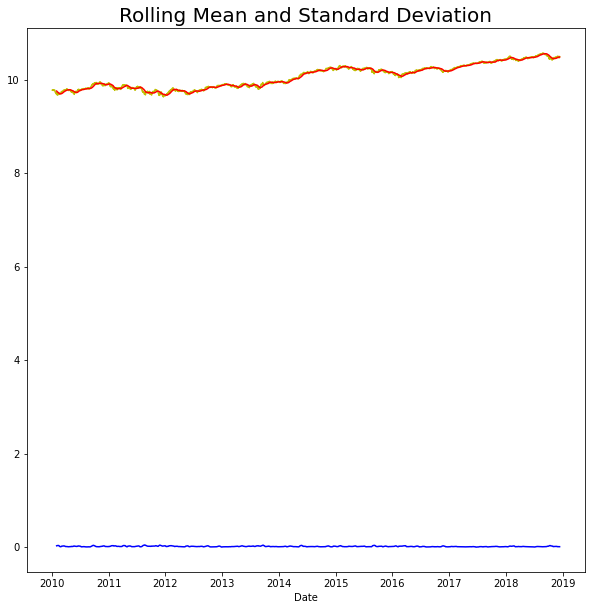

Results of Dickey Fuller test
ADF Test Statistic : -0.5242635765732802
P-Value : 0.8871940223092194
#Lags Used : 1
Number of Observations Used : 2198
Weak evidence against the null hypothesis, time series is non-stationary


In [18]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

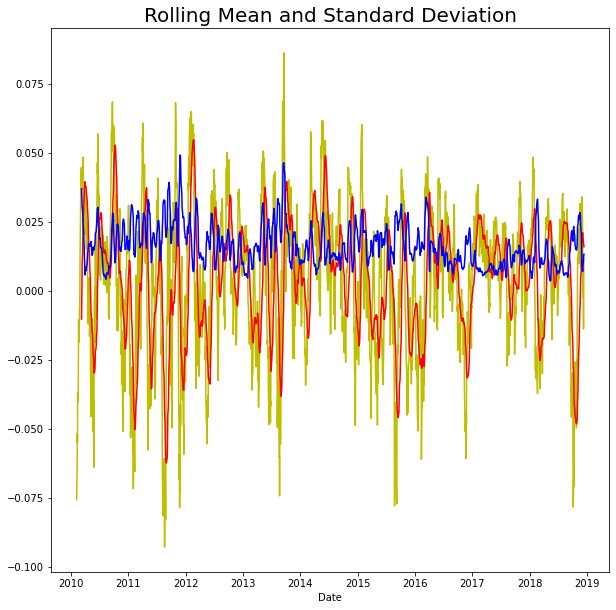

Results of Dickey Fuller test
ADF Test Statistic : -10.052024159124366
P-Value : 1.404369717063088e-17
#Lags Used : 12
Number of Observations Used : 2164
Strong evidence against the null hypothesis(HO), reject the null hypothesis. Data is stationary


In [19]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [20]:
# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
#stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2010-01-04,17558.730469,17473.449219,17582.839844,17378.380859,28200.0
2010-01-05,17686.240234,17555.769531,17729.779297,17555.769531,27000.0
2010-01-06,17701.130859,17719.470703,17790.330078,17636.710938,21400.0
2010-01-07,17615.720703,17701.970703,17733.339844,17566.539062,18000.0
2010-01-08,17540.289062,17603.869141,17658.119141,17508.960938,17200.0
...,...,...,...,...,...
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0


## News headline data cleaning and preperation

In [21]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [22]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2010-01-04,17558.730469,17473.449219,17582.839844,17378.380859,28200.0,"Bebo Khan't stop loving,Chor Bazaari top song ..."
2010-01-05,17686.240234,17555.769531,17729.779297,17555.769531,27000.0,"Women say no to one-night stands,MJ's new trac..."
2010-01-06,17701.130859,17719.470703,17790.330078,17636.710938,21400.0,Are ladies really THIS safe on Nagpur's buses?...
2010-01-07,17615.720703,17701.970703,17733.339844,17566.539062,18000.0,"Dev Patel meets the Pintos,Rahman's going gree..."
2010-01-08,17540.289062,17603.869141,17658.119141,17508.960938,17200.0,"Points table,Bicholim fire cell saved 79 lives..."
...,...,...,...,...,...,...
2020-12-24,46973.539062,46743.488281,47053.398438,46539.019531,13700.0,How to set the mood for sex during cold winter...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0,Man recovers charred remains of 'thief' from h...
2020-12-30,47746.218750,47789.031250,47807.851562,47358.359375,15600.0,Numerology Readings 30 December 2020: Predicti...


In [23]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2010-01-04,17558.730469,17473.449219,17582.839844,17378.380859,28200.0,"Bebo Khan't stop loving,Chor Bazaari top song ...",,,,
2010-01-05,17686.240234,17555.769531,17729.779297,17555.769531,27000.0,"Women say no to one-night stands,MJ's new trac...",,,,
2010-01-06,17701.130859,17719.470703,17790.330078,17636.710938,21400.0,Are ladies really THIS safe on Nagpur's buses?...,,,,
2010-01-07,17615.720703,17701.970703,17733.339844,17566.539062,18000.0,"Dev Patel meets the Pintos,Rahman's going gree...",,,,
2010-01-08,17540.289062,17603.869141,17658.119141,17508.960938,17200.0,"Points table,Bicholim fire cell saved 79 lives...",,,,


# Calculate the sentiment scores

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2010-01-04,17558.730469,17473.449219,17582.839844,17378.380859,28200.0,"Bebo Khan't stop loving,Chor Bazaari top song ...",-0.9983,0.119,0.792,0.088
2010-01-05,17686.240234,17555.769531,17729.779297,17555.769531,27000.0,"Women say no to one-night stands,MJ's new trac...",-0.9986,0.115,0.813,0.072
2010-01-06,17701.130859,17719.470703,17790.330078,17636.710938,21400.0,Are ladies really THIS safe on Nagpur's buses?...,-0.9995,0.146,0.772,0.082
2010-01-07,17615.720703,17701.970703,17733.339844,17566.539062,18000.0,"Dev Patel meets the Pintos,Rahman's going gree...",-0.9996,0.147,0.775,0.078
2010-01-08,17540.289062,17603.869141,17658.119141,17508.960938,17200.0,"Points table,Bicholim fire cell saved 79 lives...",-0.9997,0.148,0.764,0.088


In [25]:
# dropping unwanted 'headline_text' and rearranging columns
#stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2010-01-04,17558.730469,-0.9983,0.119,0.792,0.088,17473.449219,17582.839844,17378.380859,28200.0
2010-01-05,17686.240234,-0.9986,0.115,0.813,0.072,17555.769531,17729.779297,17555.769531,27000.0
2010-01-06,17701.130859,-0.9995,0.146,0.772,0.082,17719.470703,17790.330078,17636.710938,21400.0
2010-01-07,17615.720703,-0.9996,0.147,0.775,0.078,17701.970703,17733.339844,17566.539062,18000.0
2010-01-08,17540.289062,-0.9997,0.148,0.764,0.088,17603.869141,17658.119141,17508.960938,17200.0


In [26]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

Statistical data using pd.describe function

In [27]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2.701000e+03
mean,26743.693164,-0.943320,0.131423,0.779324,0.089244,26775.115166,26911.642637,26586.285010,1.315753e+05
std,7925.319230,0.321178,0.017553,0.022253,0.013706,7940.489054,7961.260007,7888.492287,1.438145e+06
min,15175.080078,-1.000000,0.070000,0.705000,0.046000,15436.120117,15440.099609,15135.860352,2.500000e+03
25%,19177.929688,-0.999900,0.121000,0.764000,0.080000,19218.130859,19344.279297,19015.050781,9.700000e+03
50%,26489.560547,-0.999700,0.132000,0.776000,0.089000,26499.810547,26678.599609,26357.349609,1.250000e+04
75%,33626.968750,-0.999300,0.143000,0.791000,0.098000,33664.269531,33848.421875,33465.230469,1.720000e+04
max,47751.328125,0.999900,0.199000,0.870000,0.159000,47789.031250,47896.968750,47602.121094,3.181510e+07


In [28]:
#display stock data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2701 entries, 2010-01-04 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     2701 non-null   float64
 1   compound  2701 non-null   float64
 2   negative  2701 non-null   float64
 3   neutral   2701 non-null   float64
 4   positive  2701 non-null   float64
 5   Open      2701 non-null   float64
 6   High      2701 non-null   float64
 7   Low       2701 non-null   float64
 8   Volume    2701 non-null   float64
dtypes: float64(9)
memory usage: 211.0 KB


Text(0, 0.5, 'Close Price INR')

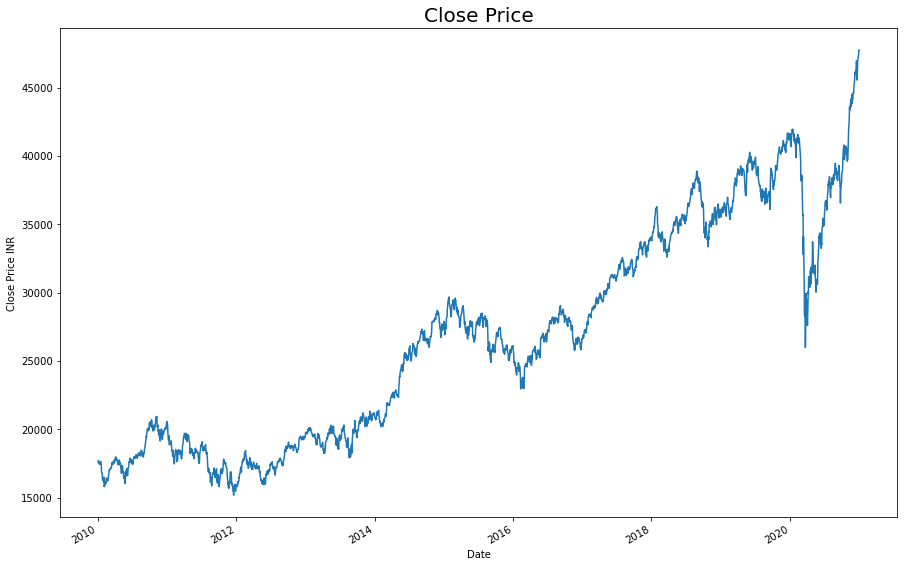

In [29]:
#Setting plotsize and labels

plt.figure(figsize=(15,10))

stock_data['Close'].plot()

plt.title("Close Price", fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Close Price INR')


In [30]:
#Calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,17578.761719,-0.998843,0.132286,0.783429,0.084143,17616.174107,17697.568359,17505.671596,21257.142857
2010-01-13,17571.771763,-0.998986,0.135571,0.780000,0.084429,17601.114118,17689.778460,17491.111607,20971.428571
2010-01-14,17557.290179,-0.998529,0.137714,0.771571,0.090857,17596.820033,17675.244141,17486.817522,20457.142857
2010-01-15,17536.314453,-0.998329,0.131714,0.780571,0.087857,17580.368583,17653.746931,17471.445871,19914.285714


<AxesSubplot:>

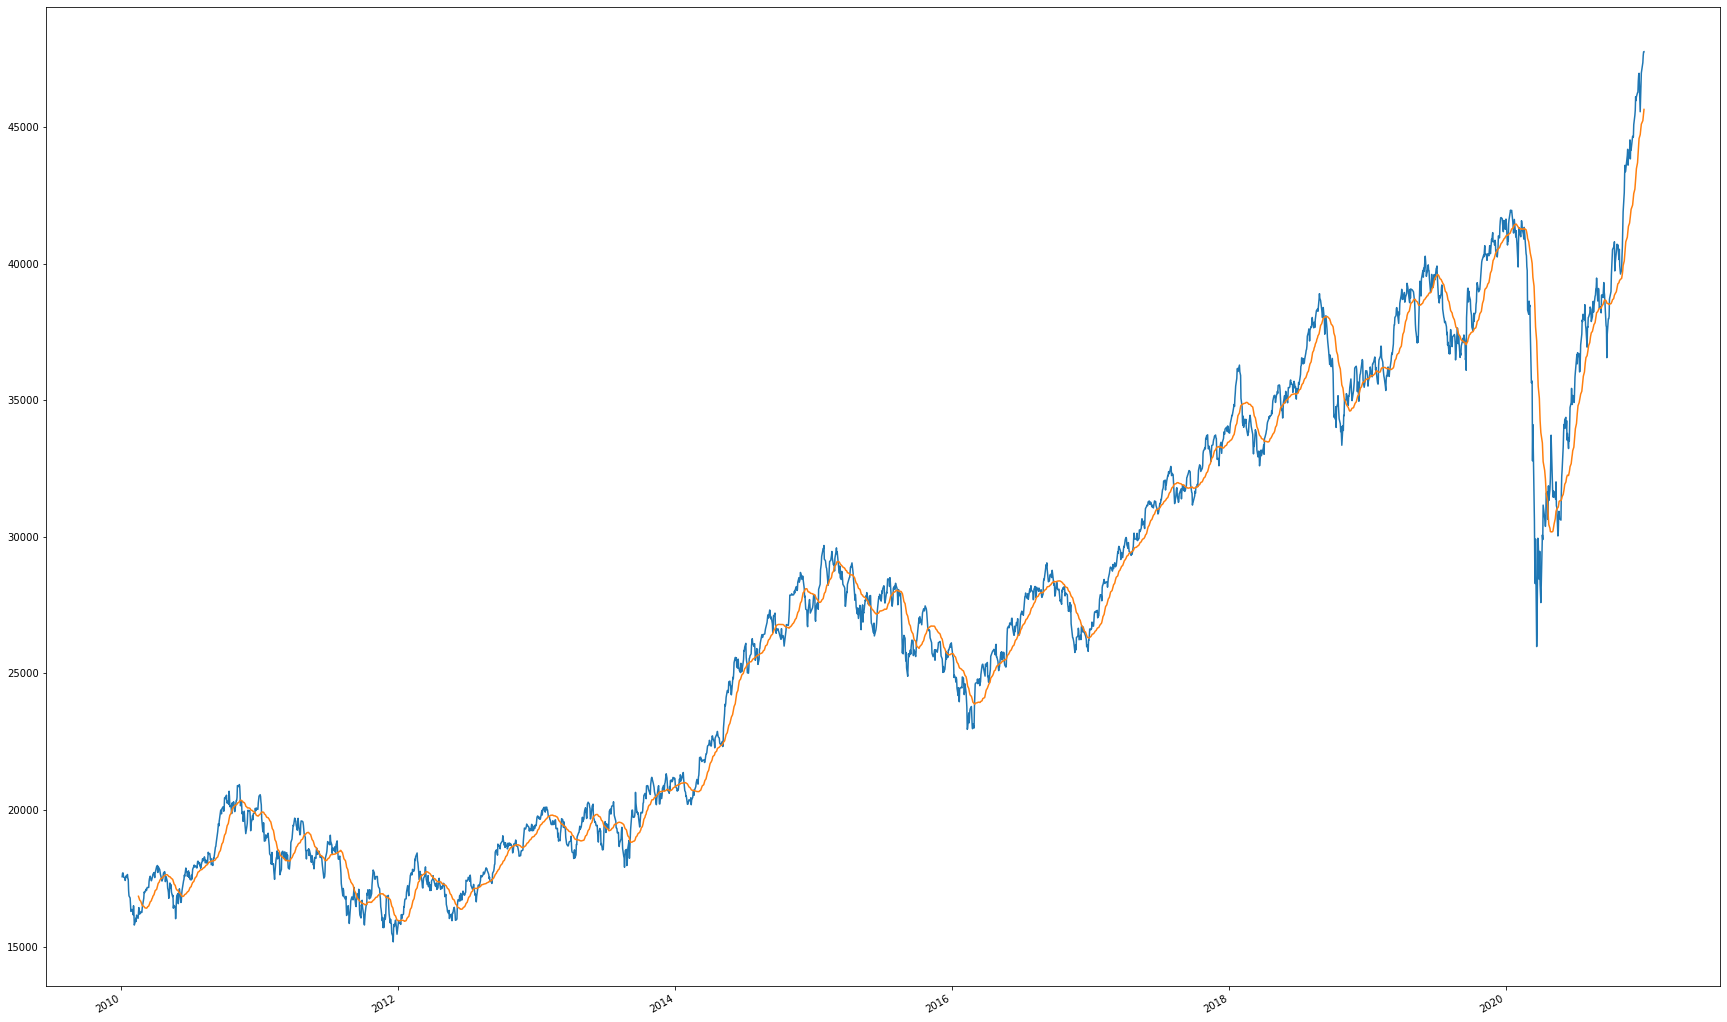

In [31]:
#Set the figure size for plotting

plt.figure(figsize=(30,20))

#Plotting the close price and a 30 day rolling mean of the close price

stock_data['Close'].plot()
stock_data.rolling(30).mean()['Close'].plot()

In [32]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 2160
Number of records in Test Data: 541


In [33]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2010-01-05    17686.240234
2010-01-06    17701.130859
2010-01-07    17615.720703
2010-01-08    17540.289062
2010-01-11    17526.710938
                  ...     
2020-12-24    46973.539062
2020-12-28    47353.750000
2020-12-29    47613.078125
2020-12-30    47746.218750
2020-12-31    47751.328125
Name: Close, Length: 2700, dtype: float64

In [34]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2010-01-05,17686.240234,17701.130859,-0.9986,-0.9995,27000.0,17555.769531,17729.779297,17555.769531
2010-01-06,17701.130859,17615.720703,-0.9995,-0.9996,21400.0,17719.470703,17790.330078,17636.710938
2010-01-07,17615.720703,17540.289062,-0.9996,-0.9997,18000.0,17701.970703,17733.339844,17566.539062
2010-01-08,17540.289062,17526.710938,-0.9997,-0.9988,17200.0,17603.869141,17658.119141,17508.960938
2010-01-11,17526.710938,17422.509766,-0.9988,-0.9974,18400.0,17724.589844,17776.570312,17500.789062
2010-01-12,17422.509766,17509.800781,-0.9974,-0.9993,18600.0,17534.099609,17612.000000,17392.550781
2010-01-13,17509.800781,17584.869141,-0.9993,-0.9954,26200.0,17368.029297,17528.310547,17276.460938
2010-01-14,17584.869141,17554.300781,-0.9954,-0.9981,23400.0,17525.710938,17628.039062,17525.710938
2010-01-15,17554.300781,17641.080078,-0.9981,-0.9987,17600.0,17604.310547,17639.849609,17529.109375
2010-01-18,17641.080078,17486.060547,-0.9987,-0.9756,15400.0,17538.720703,17712.599609,17505.500000


In [35]:

#close price shifted set as the target var
y = data['close_price_shifted']
y

2010-01-05    17701.130859
2010-01-06    17615.720703
2010-01-07    17540.289062
2010-01-08    17526.710938
2010-01-11    17422.509766
                  ...     
2020-12-23    46973.539062
2020-12-24    47353.750000
2020-12-28    47613.078125
2020-12-29    47746.218750
2020-12-30    47751.328125
Name: close_price_shifted, Length: 2699, dtype: float64

In [36]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2010-01-05,17686.240234,-0.9986,-0.9995,27000.0,17555.769531,17729.779297,17555.769531
2010-01-06,17701.130859,-0.9995,-0.9996,21400.0,17719.470703,17790.330078,17636.710938
2010-01-07,17615.720703,-0.9996,-0.9997,18000.0,17701.970703,17733.339844,17566.539062
2010-01-08,17540.289062,-0.9997,-0.9988,17200.0,17603.869141,17658.119141,17508.960938
2010-01-11,17526.710938,-0.9988,-0.9974,18400.0,17724.589844,17776.570312,17500.789062
...,...,...,...,...,...,...,...
2020-12-23,46444.179688,-0.9996,-0.9971,10500.0,46072.300781,46513.320312,45899.101562
2020-12-24,46973.539062,-0.9971,-0.9997,13700.0,46743.488281,47053.398438,46539.019531
2020-12-28,47353.750000,-0.9997,-0.9998,9600.0,47153.589844,47406.718750,47148.238281
2020-12-29,47613.078125,-0.9998,-0.9998,12800.0,47466.621094,47714.550781,47361.898438


In [37]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [38]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.84580458, -0.99859993, -0.99949997, ..., -0.86896701,
         -0.85852093, -0.84981653],
        [-0.84489024, -0.99949997, -0.99959998, ..., -0.85884729,
         -0.85477951, -0.84479317],
        [-0.85013477, -0.99959998, -0.99969998, ..., -0.85992911,
         -0.85830093, -0.84914815],
        ...,
        [ 0.97590083, -0.99969998, -0.99979999, ...,  0.96071813,
          0.97521405,  0.98673991],
        [ 0.99182463, -0.99979999, -0.99979999, ...,  0.98006917,
          0.99423495,  1.        ],
        [ 1.        , -0.99979999, -0.99959998, ...,  1.        ,
          1.        ,  0.99978036]]),
 array([[-0.84491457],
        [-0.85015827],
        [-0.85478936],
        ...,
        [ 0.99151222],
        [ 0.99968631],
        [ 1.        ]]))

In [39]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (2160, 7) and y: (2160, 1)
Number of rows and columns in Test set X: (538, 7) and y: (538, 1)


In [40]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (2160, 7)
Shape of Test set X: (538, 7)


In [41]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)
predictions = dec_tree.predict(X_test)

In [42]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))


[0.17413084 0.18111085 0.15208856 0.14191051 0.10515612 0.11644646
 0.18311169 0.14641509 0.16082311 0.19645634]
[[0.16399524]
 [0.14636593]
 [0.15783014]
 [0.13671837]
 [0.1157963 ]
 [0.15988301]
 [0.14906105]
 [0.18288458]
 [0.1822656 ]
 [0.2178547 ]]
0.016282082849133343


In [43]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(X_train, y_train)

LGBMRegressor()

In [44]:
predictions = lgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.021312692989706727


In [45]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
predictions = xgb.predict(X_test)
print(mean_squared_error(predictions,y_test))

0.016951346982922787


In [47]:
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
predictions = adb.predict(X_test)

In [48]:
print(mean_squared_error(predictions, y_test))

0.024233640004686755


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

## Create a Tensorflow model

In [130]:
model = Sequential()

# input layer
model.add(Dense(10,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [131]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=10,
          batch_size=256,
          validation_data=(X_test, y_test), 
          )

Epoch 1/10
9/9 [==============================] - 0s 11ms/step - loss: 0.8488 - val_loss: 0.6958
Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.7764 - val_loss: 0.6936
Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.7077 - val_loss: 0.6947
Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.6511 - val_loss: 0.6911
Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.5844 - val_loss: 0.6844
Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4706 - val_loss: 0.6800
Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3537 - val_loss: 0.6776
Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2495 - val_loss: 0.6771
Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1305 - val_loss: 0.6784
Epoch 10/10
9/9 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.6815


In [132]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

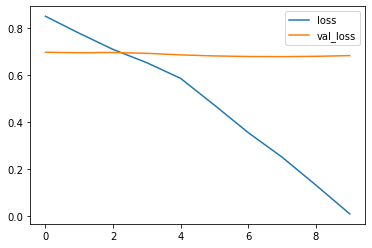

In [133]:
losses[['loss','val_loss']].plot()

Thank you!